In [37]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import graycomatrix, graycoprops

# Configuración
BASE_DIR = 'data' 
CLASSES = ['fire', 'smoke', 'neutral']
class_map = {name: i for i, name in enumerate(CLASSES)}

dataset = {cls: [] for cls in CLASSES}
image_paths = {cls: [] for cls in CLASSES}

def load_images_from_folder(folder_path, label):
    loaded_images = []
    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    
    for ext in extensions:
        files.extend(glob.glob(os.path.join(folder_path, ext)))
        
    files.sort()
    
    print(f"  Encontrados {len(files)} archivos en '{folder_path}'")
    
    for file_path in files:
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            loaded_images.append(img)
            image_paths[label].append(file_path)
            
    return loaded_images

print("Cargando dataset...")
for cls in CLASSES:
    path = os.path.join(BASE_DIR, cls)
    if os.path.exists(path):
        print(f"Procesando carpeta: {path}")
        dataset[cls] = load_images_from_folder(path, cls)
    else:
        print(f"⚠️ Error: La ruta {path} no existe.")

print("-" * 30)
for cls in CLASSES:
    print(f"Total imágenes cargadas [{cls}]: {len(dataset[cls])}")


def get_final_features(img_rgb):
    """
    Extrae las características del modelo ganador (High Res).
    - Color: HSV (Saturación y BRILLO/VALOR), YCbCr (Cr, Cb).
    - Estructura: Canny en Saturación, Hu Moments, GLCM.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    ycbcr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    
    s = hsv[:, :, 1]
    v = hsv[:, :, 2] 
    
    _, cr, cb = cv2.split(ycbcr)
    
    mean_s = np.mean(s)
    std_s = np.std(s)
    
    mean_v = np.mean(v)
    std_v = np.std(v)
    
    mean_cr = np.mean(cr)
    std_cr = np.std(cr)
    mean_cb = np.mean(cb)
    
    edges_s = cv2.Canny(s, 50, 150)
    edge_density = np.count_nonzero(edges_s) / s.size
    
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    _, binary = cv2.threshold(cr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(binary)
    hu = cv2.HuMoments(moments).flatten()
    hu = -1 * np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    
    features = [mean_s, std_s, mean_v, std_v, mean_cr, std_cr, mean_cb, edge_density, contrast, homogeneity]
    features.extend(hu) 
    
    return features

Cargando dataset...
Procesando carpeta: data\fire
  Encontrados 29 archivos en 'data\fire'
Procesando carpeta: data\smoke
  Encontrados 31 archivos en 'data\smoke'
Procesando carpeta: data\neutral
  Encontrados 29 archivos en 'data\neutral'
------------------------------
Total imágenes cargadas [fire]: 29
Total imágenes cargadas [smoke]: 31
Total imágenes cargadas [neutral]: 29


In [92]:
X = []
y = []

for label_name in CLASSES:
    print(f"Extrayendo features: {label_name}...")
    for img in dataset[label_name]:
        try:
            feat = get_final_features(img)
            X.append(feat)
            y.append(class_map[label_name])
        except Exception as e:
            print(f"  Error en imagen de {label_name}: {e}")

X = np.array(X)
y = np.array(y)

if len(X) > 0:
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo
    model = DecisionTreeClassifier(max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    # Validación
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"\n✅ Modelo Entrenado. Accuracy en Test: {acc*100:.2f}%")
else:
    print("\nError: No se extrajeron características. Verifica las rutas de las imágenes.")

Extrayendo features: fire...
Extrayendo features: smoke...
Extrayendo features: neutral...

✅ Modelo Entrenado. Accuracy en Test: 77.78%


In [93]:
def predecir_fuego(img):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    features = get_final_features(img)
    
    # Predicción
    prediction_idx = model.predict(np.array(features).reshape(1, -1))[0]
    prediction_name = CLASSES[prediction_idx]
    
    # Confianza
    probs = model.predict_proba(np.array(features).reshape(1, -1))[0]
    confidence = probs[prediction_idx] * 100
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    color_tit = 'red' if prediction_name == 'fire' else 'green'
    plt.title(f"Predicción: {prediction_name.upper()}\nConfianza: {confidence:.1f}%", 
              color=color_tit, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

In [130]:
fire1 = cv2.imread("./test/fireTest01.jpg")
fire2 = cv2.imread("./test/fireTest02.jpg")
smoke1 = cv2.imread("./test/smokeTest01.jpg")
smoke2 = cv2.imread("./test/smokeTest02.jpg")
forest1 = cv2.imread("./test/forestTest01.jpg")
forest2 = cv2.imread("./test/forestTest02.jpg")

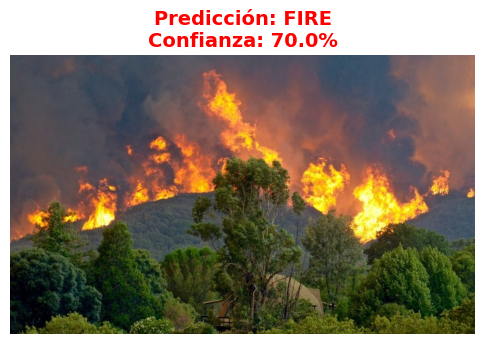

In [132]:
predecir_fuego(fire1)

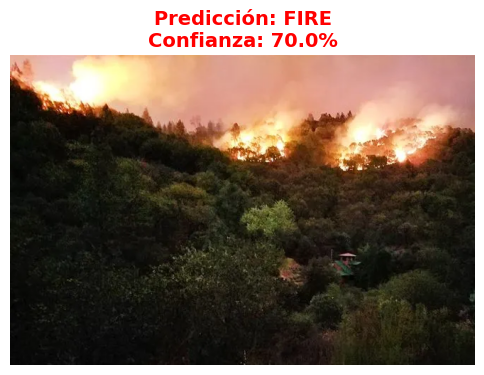

In [134]:
predecir_fuego(fire2)

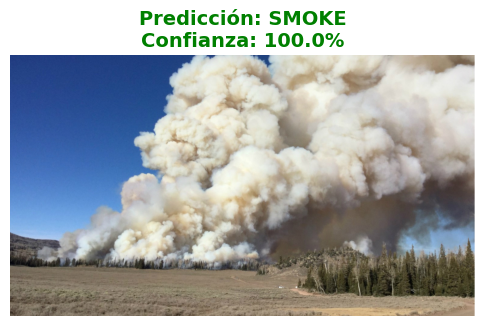

In [136]:
predecir_fuego(smoke1)

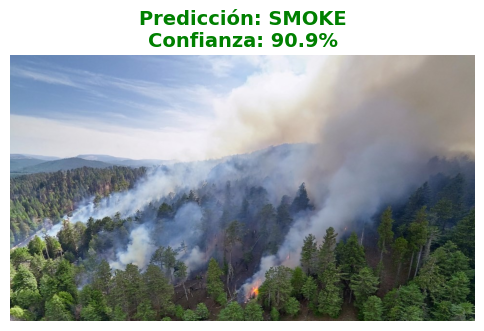

In [138]:
predecir_fuego(smoke2)

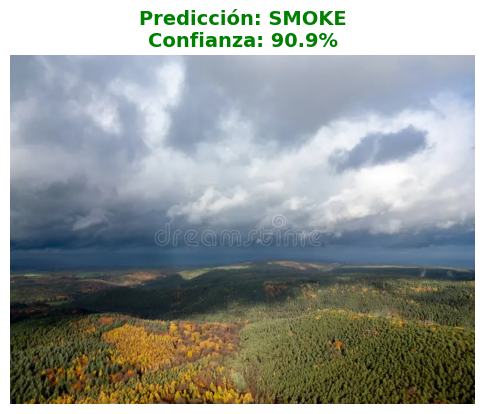

In [140]:
predecir_fuego(forest1)

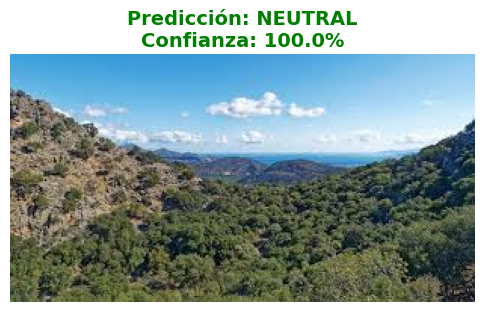

In [142]:
predecir_fuego(forest2)